In [13]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm.notebook import tqdm
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import os
from PIL import Image

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Unzip the dataset
zip_path = '/content/drive/MyDrive/Flickr30k.zip'
extract_path = '/content/Flickr30k'

In [16]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [17]:
image_path = os.path.join(extract_path, 'flickr30k_images')
# features_path = '/content/drive/MyDrive/features.pkl'
# tokenizer_path= '/content/drive/MyDrive/tokenizer.pkl'

In [33]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("features.pkl", "rb") as f:
    features = pickle.load(f)

with open("config.pkl", "rb") as f:
    config = pickle.load(f)
max_length = config['max_length']
vocab_size = config['vocab_size']

data = pd.read_pickle("captions.pkl")
caption_model = load_model("model.keras")

In [19]:
# Create an empty dictionary to store index-to-word mapping
index_word = {}

# Go through each word and its index in the tokenizer's word_index
for word, index in tokenizer.word_index.items():
    # Set the index as the key and the word as the value
    index_word[index] = word

In [20]:
def predict_caption(model, image_name, tokenizer, max_length, features):
    key = image_name if image_name.endswith(".jpg") else image_name + ".jpg"

    if key not in features:
        print(f"⚠️ Image '{key}' not found in features.")
        return ""

    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([features[key], sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()

In [21]:
def evaluate_model_bleu(model, test_df, tokenizer, max_length, features):
    """
    Evaluate the model on the test set using BLEU-1 to BLEU-4 scores.
    """
    actual, predicted = [], []

    image_names = test_df['image_name'].unique()

    for image_name in tqdm(image_names):
        refs = test_df[test_df['image_name'] == image_name]['comment'].tolist()
        refs = [ref.split() for ref in refs]

        pred = predict_caption(model, image_name, tokenizer, max_length, features)
        pred = pred.split()

        actual.append(refs)
        predicted.append(pred)

    # Compute BLEU scores
    scores = {
        "BLEU-1": corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
        "BLEU-2": corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)),
        "BLEU-3": corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)),
        "BLEU-4": corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    }

    print("\nBLEU Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    return scores


In [22]:
# Load test set
test = pd.read_pickle("test.pkl")  # Ensure this is created during data preparation

# Evaluate BLEU scores
bleu_scores = evaluate_model_bleu(caption_model, test, tokenizer, max_length, features)

  0%|          | 0/6357 [00:00<?, ?it/s]


BLEU Scores:
BLEU-1: 0.4355
BLEU-2: 0.2256
BLEU-3: 0.1191
BLEU-4: 0.0594


In [23]:
def evaluate_model_bleu_with_smoothning(model, test_df, tokenizer, max_length, features):
    """
    Evaluate the model on the test set using BLEU-1 to BLEU-4 scores.
    """
    smoothie = SmoothingFunction().method1
    actual, predicted = [], []

    image_names = test_df['image_name'].unique()

    for image_name in tqdm(image_names):
        refs = test_df[test_df['image_name'] == image_name]['comment'].tolist()
        refs = [ref.split() for ref in refs]

        pred = predict_caption(model, image_name, tokenizer, max_length, features)
        pred = pred.split()

        actual.append(refs)
        predicted.append(pred)

    # Compute BLEU scores
    scores = {
        "BLEU-1": corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function= smoothie),
        "BLEU-2": corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function= smoothie),
        "BLEU-3": corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function= smoothie),
        "BLEU-4": corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function= smoothie)
    }

    print("\nBLEU Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    return scores


In [24]:
# Evaluate BLEU scores
bleu_scores = evaluate_model_bleu_with_smoothning(caption_model, test, tokenizer, max_length, features)

  0%|          | 0/6357 [00:00<?, ?it/s]


BLEU Scores:
BLEU-1: 0.4355
BLEU-2: 0.2256
BLEU-3: 0.1191
BLEU-4: 0.0594


In [44]:
def display_caption(image_name, model, tokenizer, max_length, features, captions_df, images_path):
    # 1. Ensure .jpg extension for image file access
    if not image_name.endswith('.jpg'):
        image_name += '.jpg'

    # 2. Show the image
    image_path = os.path.join(images_path, image_name)
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image: " + image_name)
        plt.show()
    except FileNotFoundError:
        print(f"⚠️ Image not found at: {image_path}")
        return

    # 3. Normalize image name format for matching
    base_name = image_name.strip().lower()

    if 'image_name_clean' not in captions_df.columns:
        captions_df['image_name_clean'] = captions_df['image_name'].str.strip().str.lower()

    # 4. Show actual captions
    print("\n🔹 Actual Captions:")
    actual_captions = captions_df[captions_df['image_name_clean'] == base_name]['comment'].tolist()

    if actual_captions:
        for i, caption in enumerate(actual_captions):
            cleaned_caption = caption.replace('startseq', '').replace('endseq', '').strip()
            print(f"{i+1}. {cleaned_caption}")
    else:
        print("⚠️ No matching captions found for this image.")

    # 5. Show predicted caption
    print("\n🤖 Predicted Caption:")
    image_key = image_name.replace('.jpg', '')
    predicted_caption = predict_caption(model, image_key, tokenizer, max_length, features)
    print(predicted_caption)

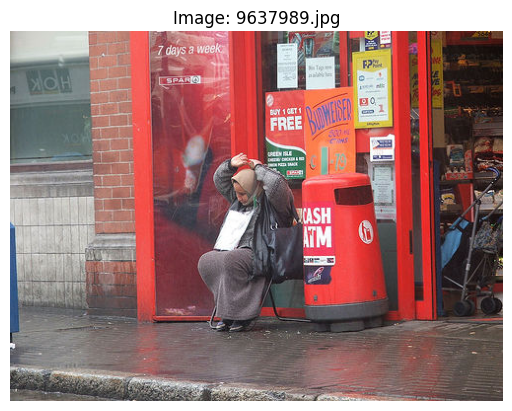


🔹 Actual Captions:
1. woman sits outside of shop while she has some sort of sign on her lap
2. woman with black purse waiting at an orange bus stop
3. woman sitting in front of shop next to trashcan
4. lady sitting in chair outdoors in the rain
5. woman in gray sitting with her hands up

🤖 Predicted Caption:
man in black shirt is sitting on the ground


In [46]:
display_caption("9637989", caption_model, tokenizer, max_length, features, data, image_path)